In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import terra
import meerkat as mk
from domino.data.visual_genome import read_vg, ATTRIBUTE_GROUPS
import numpy as np
import pandas as pd
from rich import print
import sys
sys.path.insert(1,'/pd/maya/domino/domino')

In [3]:
#for p in sys.path:
#    print(p)

## MIMIC Slice Experiments

### Generate Slices

In [4]:
import slices.mimic

In [5]:
dataset_dir = '/pd/maya/mimic_dp_adjusted_diagnoses.mk'

In [6]:
target = 'lung_group'
correlate = 'support_devices'

In [7]:
dp = slices.mimic.build_correlation_slice(target, correlate, 0.8, 1e4, dataset_dir)
dp.shape

(9997, 66)

In [8]:
print('target: ' + target + f'==1: {np.sum(dp[target]==1)}')
print('correlate: ' + correlate + f'==1: {np.sum(dp[correlate]==1)}')
print(f'{target}==1 and {correlate}==1: {np.sum((dp[correlate]==1) & (dp[target]==1))}')
print(f'{target}==0 and {correlate}==0: {np.sum((dp[correlate]==0) & (dp[target]==0))}')
print(f'{target}==1 and {correlate}==0: {np.sum((dp[correlate]==0) & (dp[target]==1))}')
print(f'{target}==0 and {correlate}==1: {np.sum((dp[correlate]==1) & (dp[target]==0))}')

target: lung_group==1: 2228

correlate: support_devices==1: 2228

lung_group==1 and support_devices==1: 1882

lung_group==0 and support_devices==0: 7423

lung_group==1 and support_devices==0: 346

lung_group==0 and support_devices==1: 346

In [9]:
import utils

In [10]:
splits = utils.split_dp(dp, split_on="dicom_id")

task: split_dp, run_id=11619


,dicom_id (PandasSeriesColumn),study_id (PandasSeriesColumn),subject_id (PandasSeriesColumn),dicom_path (PandasSeriesColumn),gender (PandasSeriesColumn),anchor_age (PandasSeriesColumn),anchor_year (PandasSeriesColumn),anchor_year_group (PandasSeriesColumn),dod (PandasSeriesColumn),dicom (PandasSeriesColumn),study_date (PandasSeriesColumn),image_type (PandasSeriesColumn),table_type (PandasSeriesColumn),distance_source_to_detector (PandasSeriesColumn),distance_source_to_patient (PandasSeriesColumn),exposure (PandasSeriesColumn),exposure_time (PandasSeriesColumn),x_ray_tube_current (PandasSeriesColumn),field_of_view_rotation (PandasSeriesColumn),field_of_view_origin (PandasSeriesColumn),field_of_view_horizontal_flip (PandasSeriesColumn),view_position (PandasSeriesColumn),patient_orientation (PandasSeriesColumn),burned_in_annotation (PandasSeriesColumn),requesting_service (PandasSeriesColumn),detector_primary_angle (PandasSeriesColumn),detector_element_physical_size (PandasSeriesColumn),report_path (PandasSeriesColumn),hadm_id (PandasSeriesColumn),admittime (PandasSeriesColumn),dischtime (PandasSeriesColumn),deathtime (PandasSeriesColumn),admission_type (PandasSeriesColumn),admission_location (PandasSeriesColumn),discharge_location (PandasSeriesColumn),insurance (PandasSeriesColumn),language (PandasSeriesColumn),marital_status (PandasSeriesColumn),ethnicity (PandasSeriesColumn),edregtime (PandasSeriesColumn),edouttime (PandasSeriesColumn),hospital_expire_flag (PandasSeriesColumn),index (PandasSeriesColumn),jpg_path (PandasSeriesColumn),cxr_jpg (GCSImageColumn),cxr_dicom (GCSImageColumn),cxr_jpg_1024 (ImageColumn),atelectasis (PandasSeriesColumn),cardiomegaly (PandasSeriesColumn),consolidation (PandasSeriesColumn),edema (PandasSeriesColumn),enlarged_cardiomediastinum (PandasSeriesColumn),fracture (PandasSeriesColumn),lung_lesion (PandasSeriesColumn),lung_opacity (PandasSeriesColumn),no_finding (PandasSeriesColumn),pleural_effusion (PandasSeriesColumn),pleural_other (PandasSeriesColumn),pneumonia (PandasSeriesColumn),pneumothorax (PandasSeriesColumn),support_devices (PandasSeriesColumn),finding_group (PandasSeriesColumn),lung_group (PandasSeriesColumn),pleural_group (PandasSeriesColumn),cardio_group (PandasSeriesColumn),split (PandasSeriesColumn)
0,9b46f451-37a628e4-177ad98b-67e92d76-182948b4,58716053,12112188,files/p12/p12112188/s58716053/9b46f451-37a628e4-177ad98b-67e92d76-182948b4.dcm,F,53.0,2123.0,2011 - 2013,None,9b46f451-37a628e4-177ad98b-67e92d76-182948b4,21231020.0,"['DERIVED', 'PRIMARY']",None,NaN,NaN,NaN,NaN,NaN,NaN,None,None,AP,"['L', 'F']",YES,EU,NaN,"['139', '139']",files/p12/p12112188/s58716053.txt,23296004.0,2123-10-19 22:28:00,2123-10-20 16:46:00,NaT,EU OBSERVATION,EMERGENCY ROOM,None,Other,ENGLISH,SINGLE,HISPANIC/LATINO,2123-10-19 21:38:00,2123-10-20 16:46:00,0.0,47417,files/p12/p12112188/s58716053/9b46f451-37a628e4-177ad98b-67e92d76-182948b4.jpg,LambdaCell,LambdaCell,,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,False,False,False,train
1,768f9611-a3d9379a-0c0c5cd1-44066ab8-371a5d27,52407270,16435274,files/p16/p16435274/s52407270/768f9611-a3d9379a-0c0c5cd1-44066ab8-371a5d27.dcm,F,21.0,2126.0,2011 - 2013,None,768f9611-a3d9379a-0c0c5cd1-44066ab8-371a5d27,21260526.0,"['DERIVED', 'PRIMARY']",FIXED,1830.0,NaN,2.0,17.0,125.0,NaN,None,None,PA,"['R', 'F']",NO,EU,NaN,"['0.139', '0.139']",files/p16/p16435274/s52407270.txt,NaN,NaT,NaT,NaT,None,None,None,None,None,None,None,NaT,NaT,NaN,128609,files/p16/p16435274/s52407270/768f9611-a3d9379a-0c0c5cd1-44066ab8-371a5d27.jpg,LambdaCell,LambdaCell,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,test
2,4b8d0145-7eb86336-8977eea1-b78595b5-cda8065d,50890505,10737274,files/p10/p10737274/s50890505/4b8d0145-7eb86336-8977eea1-b78595b5-cda8065d.dcm,M,81.0,2141.0,2008 - 2010,None,4b8d0145-7eb86336-8977eea1-b78595b5-cda8065d,21470327.0,"['DERIVED', 'PRIMARY']",TILTING,NaN,NaN,3.0,10.0,320.0,NaN,None,None,AP,"['L', 'F']",YES,MED,NaN,"['0.139', '0.139']",files/p10/p10737274/s50890505.txt,23439125.0,21
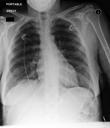
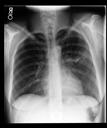
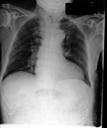
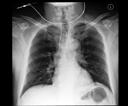
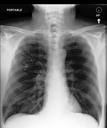

In [11]:
splits = splits.load()
dp['split'] = splits['split']
dp.head()

### Train Model

In [12]:
import terra 
from vision import train
from torchvision import transforms

preprocessing = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


dp["input"] = dp["cxr_jpg_1024"].to_lambda(preprocessing)

@terra.Task
def train_vg(dp, run_dir: str = None):

    model = train(
        config={"pretrained": True, 'transform': None, 'train_transform': None},
        dp=dp,
        input_column="input",
        max_epochs=5,
        id_column="dicom_id",
        target_column=target,
        ckpt_monitor="valid_auroc",
        batch_size=128, 
        run_dir=run_dir,
        val_check_interval=10,
        num_workers=6
    )
    return model

train_vg(dp=dp)

/home/sabri/code/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


task: train_vg, run_id=11620


[2021-09-16 16:57:29,950][INFO][pytorch_lightning.utilities.seed:65] :: Global seed set to 123
/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Checkpoint directory /home/sabri/terra/slice/tasks/__main__/train_vg/_runs/11620 exists and is not empty.
  warnings.warn(*args, **kwargs)
[2021-09-16 16:57:33,920][INFO][pytorch_lightning.utilities.distributed:73] :: GPU available: True, used: True
[2021-09-16 16:57:33,921][INFO][pytorch_lightning.utilities.distributed:73] :: TPU available: False, using: 0 TPU cores
[2021-09-16 16:57:33,942][INFO][pytorch_lightning.accelerators.gpu:63] :: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged 

[2021-09-16 16:57:40,737][INFO][pytorch_lightning.core.lightning:1496] :: 
  | Name        | Type       | Params
-------------------------------------------
0 | model       | ResNet     | 11.2 M
1 | metrics     | ModuleDict | 0     
2 | valid_preds | PredLogger | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)



InvalidVersionSpec: Invalid version '.1.4.0': empty version component

[2021-09-16 16:57:45,543][INFO][pytorch_lightning.utilities.seed:65] :: Global seed set to 123


train_loss,0.00251
epoch,4
trainer/global_step,274
_runtime,253
_timestamp,1631811707
_step,299
valid_loss,0.6159
valid_accuracy,0.84415
valid_auroc,0.85169


train_loss,█▆▆▆▄▆▆▅▃▃▃▄▃▄▄▃▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
valid_loss,▄▂▂▁▂▁▂▂▃▂▃▃▄▄▄▆▇▆▇▇▇████
valid_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇█████████████
valid_auroc,▁▄▆▇▇▇███████████████████


{'__run_dir__': '/home/sabri/terra/slice/tasks/__main__/train_vg/_runs/11620', '__key__': '61d1418c6fcd4b989f5a4d82b0f59db2', '__type__': <class 'vision.Classifier'>, '__id__': 188448}

In [7]:
run_id = 11620
dataset_dp = terra.inp(run_id)["dp"].load()
model = terra.get_artifacts(run_id, "best_chkpt")["model"]

/home/sabri/code/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


### Score Model

In [8]:
from domino.vision import score
score_dp = score(
    model=model.load(), 
    dp=dataset_dp.lz[dataset_dp["split"] == "test"], 
    input_column="input",
    batch_size=128
)

/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [9]:
score_dp["prob"] = score_dp["output"].probabilities().data[:, -1]

In [10]:
from sklearn.metrics import roc_auc_score
print("Overall AUROC: {}".format(
    roc_auc_score(score_dp[target], score_dp["prob"])
))

curr_dp = score_dp.lz[score_dp[target] == score_dp[correlate]]
print("AUROC where correlation holds: {}".format(
    roc_auc_score(curr_dp[target], curr_dp["prob"])
))

curr_dp = score_dp.lz[score_dp[target] != score_dp[correlate]]
print("AUROC where correlation does not hold: {}".format(
    roc_auc_score(curr_dp[target], curr_dp["prob"])
))

Overall AUROC: 0.86695713836422

AUROC where correlation holds: 0.900248376326855

AUROC where correlation does not hold: 0.3979508196721312

### Analyze with CLIP Embeddings

In [11]:
from emb.clip import embed_images
score_dp = embed_images(dp=score_dp, img_column="cxr_jpg_1024").load()

task: embed_images, run_id=11805


In [12]:
from emb.clip import embed_words, get_wiki_words
#words_dp = get_wiki_words()
#words_dp = embed_words(words_dp).load()
words_dp = embed_words.out(6537).load()
words_dp = words_dp.lz[:int(1e4)]

,cxr_jpg_1024 (ImageColumn),prob (TensorColumn),lung_group (PandasSeriesColumn),support_devices (PandasSeriesColumn)
0,,tensor(0.0048),True,1.0
1,,tensor(0.0091),True,0.0
2,,tensor(0.0059),True,1.0
3,,tensor(0.1704),True,1.0
4,,tensor(0.0125),True,1.0
...,...,...,...,...
172,,tensor(0.3862),True,0.0
173,,tensor(0.3179),True,1.0
174,,tensor(0.0474),True,0.0
175,,tensor(0.4293),True,1.0

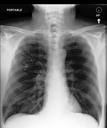
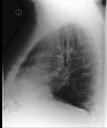
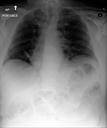
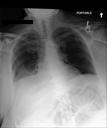
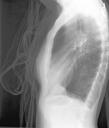
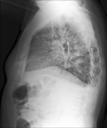
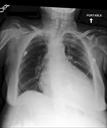
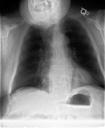
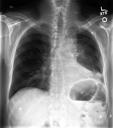
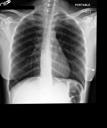

In [13]:
mk.config.DisplayOptions.max_rows = 10
error_dp = score_dp.lz[(score_dp["prob"] > 0.5).numpy() != (score_dp[target] == 1)]
error_dp = error_dp.lz[(error_dp[target] == 1)]
error_dp[["cxr_jpg_1024", "prob", target, correlate]]

In [14]:
mk.config.DisplayOptions.max_rows = 40

dp = score_dp
prob_indices = (dp["prob"] > 0.5).data.numpy().astype(bool)
attr_emb = dp.lz[prob_indices]["emb"].data.mean(axis=0) #average embedding of predicted lung images
ref_emb = dp.lz[dp[target] == 1]["emb"].data.mean(axis=0) #average embedding of true lung images

#error_1_indices = ((dp["prob"] > 0.5).data.numpy().astype(bool)) & ((dp[target] == 0).data.astype(bool))
#error_1_emb =  dp.lz[error_1_indices]["emb"].data.mean(axis=0)

#error_2_indices = ((dp["prob"] < 0.5).data.numpy().astype(bool)) & ((dp[target] == 1).data.astype(bool))
#error_2_emb =  dp.lz[error_2_indices]["emb"].data.mean(axis=0)

scores = np.dot(words_dp["emb"].data, attr_emb - ref_emb)
words_dp["score"] = scores
words_dp.lz[(-scores).argsort()[:20]]

,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn),tokens (LambdaColumn),emb (NumpyArrayColumn),score (NumpyArrayColumn)
0,instrumentation,14720,9795,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.200928
1,controls,44114,4378,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.189331
2,connected,132956,1666,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.189331
3,antenna,19528,8033,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.182739
4,electronics,38830,4864,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.174072
5,electrical,71316,2947,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.169189
6,gameplay,38580,4890,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.167236
7,connections,56383,3570,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.165894
8,electrons,16851,8909,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.163574
9,constellation,16474,9052,LambdaCell(fn=),"np.ndarray(shape=(512,))",0.162354


### Analyze with Multimodal Embeddings

In [15]:
import pickle
ckpt_dir = '/pd/maya/rx-multimodal/classifier/checkpoints/0905_clip_vit_chexbert_frozen_findingsimpressions/'
with open(os.path.join(ckpt_dir, 'all_img_vectors.pkl'), 'rb') as f:
    keyToImgVector = pickle.load(f)
print(len(keyToImgVector))


377110

In [16]:
import pickle
ckpt_dir = '/pd/maya/rx-multimodal/classifier/checkpoints/0905_clip_vit_chexbert_frozen_findingsimpressions/'
with open(os.path.join(ckpt_dir, 'all_rep_vectors.pkl'), 'rb') as f:
    keyToRepVector = pickle.load(f)
print(len(keyToRepVector))


125417

In [17]:
word_embs = []
keys = []
for k in keyToRepVector: 
    word_embs.append(keyToRepVector[k])
    keys.append(k)

words_dp=mk.DataPanel({'word_embs': word_embs, 'key': keys})

In [18]:
dicom_ids = list(score_dp['dicom_id'])
img_vectors = []
for d in dicom_ids:
    img_vectors.append(keyToImgVector[d])
score_dp['img_emb'] = img_vectors

In [19]:
dp = score_dp
prob_indices = (dp["prob"] > 0.5).data.numpy().astype(bool)
attr_emb = dp.lz[prob_indices]["img_emb"].data.mean(axis=0) #average embedding of predicted lung images
ref_emb = dp.lz[dp[target] == 1]["img_emb"].data.mean(axis=0) #average embedding of true lung images


#error_1_indices = ((dp["prob"] > 0.5).data.numpy().astype(bool)) & ((dp[target] == 0).data.astype(bool))
#error_1_emb =  dp.lz[list(error_1_indices)]["img_emb"].data.mean(axis=0)

#error_2_indices = ((dp["prob"] < 0.5).data.numpy().astype(bool)) & ((dp[target] == 1).data.astype(bool))
#error_2_emb =  dp.lz[list(error_2_indices)]["img_emb"].data.mean(axis=0)

In [112]:
scores = np.dot(words_dp['word_embs'].data, attr_emb - ref_emb)
words_dp["score"] = scores
words_dp.lz[(-scores).argsort()[:20]]

,word_embs (NumpyArrayColumn),key (ListColumn),index (PandasSeriesColumn),score (NumpyArrayColumn)
0,"np.ndarray(shape=(256,))","('14886080', '58927318')",125280,0.088846
1,"np.ndarray(shape=(256,))","('17033046', '59877196')",30789,0.088270
2,"np.ndarray(shape=(256,))","('19139995', '56737267')",61549,0.088262
3,"np.ndarray(shape=(256,))","('13259676', '52137169')",120141,0.088254
4,"np.ndarray(shape=(256,))","('15696083', '50500087')",74326,0.088216
5,"np.ndarray(shape=(256,))","('14490385', '55935665')",54824,0.088167
6,"np.ndarray(shape=(256,))","('12394964', '51733106')",27309,0.088163
7,"np.ndarray(shape=(256,))","('19732617', '53078866')",66138,0.088158
8,"np.ndarray(shape=(256,))","('15733157', '50227161')",87028,0.088037
9,"np.ndarray(shape=(256,))","('19259478', '50670850')",861,0.087946


In [113]:
STOP_WORDS = set(
    """
a about above across after afterwards again against all almost alone along
already also although always am among amongst amount an and another any anyhow
anyone anything anyway anywhere are around as at
back be became because become becomes becoming been before beforehand behind
being below beside besides between beyond both bottom but by
call can cannot ca could
did do does doing done down due during
each eight either eleven else elsewhere empty enough even ever every
everyone everything everywhere except
few fifteen fifty first five for former formerly forty four from front full
further
get give go
had has have he hence her here hereafter hereby herein hereupon hers herself
him himself his how however hundred
i if in indeed into is it its itself
keep
last latter latterly least less
just
made make many may me meanwhile might mine more moreover most mostly move much
must my myself
name namely neither never nevertheless next nine no nobody none noone nor not
nothing now nowhere
of off often on once one only onto or other others otherwise our ours ourselves
out over own
part per perhaps please put
quite
rather re really regarding
same say see seem seemed seeming seems serious several she should show side
since six sixty so some somehow someone something sometime sometimes somewhere
still such
take ten than that the their them themselves then thence there thereafter
thereby therefore therein thereupon these they third this those though three
through throughout thru thus to together too top toward towards twelve twenty
two
under until up unless upon us used using
various very very via was we well were what whatever when whence whenever where
whereafter whereas whereby wherein whereupon wherever whether which while
whither who whoever whole whom whose why will with within without would
yet you your yours yourself yourselves
""".split()
)

MED_STOP_WORDS = ['chest', 'final', 'report', 'examination', 'examination:', 'indication', 'indication:', \
                  'technique', 'technique:', 'comparison', 'comparison:', 'findings', 'findings:', 'impression:', '___', '___.', '//']

In [85]:
from collections import Counter
import scispacy
import spacy
from scispacy.linking import EntityLinker

nlp = spacy.load("en_core_sci_sm")
nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})

/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [120]:
keys = words_dp.lz[(-scores).argsort()[:10]]['key']
all_re_words = []
for key in keys:
    path = f'p{key[0][:2]}/p{key[0]}/s{key[1]}.txt'
    report_path = os.path.join('/home/common/datasets/mimic/mimic-cxr-reports/files/', path)
    report = ''
    with open(report_path) as f:
        for line in f.readlines():
            report+=line.strip().lower()+' '
    doc = nlp(report)
    print(doc)

    words = []
    for word in report.split():
        if(word not in STOP_WORDS and word not in MED_STOP_WORDS): words.append(word)
    all_re_words.extend(list(words))

final report examination:  chest (portable ap)  indication:  ___ year old man with effusion 
and pneumothorax s/p chest tube  // ___ for pneumo, effusion  technique:  portable ap chest 
radiograph.  comparison:  chest radiograph ___  findings:  support lines and tubes are 
unchanged in position when compared to the prior study.  there is a persistent airspace 
opacity in the right upper lobe, unchanged compared to the prior study.  the right apical 
pneumothorax is not definitely visualized on today's study.  certainly this has not 
significantly increased.  there is a small left pleural effusion, similar when compared to 
the prior study.  mild prominence of the pulmonary vasculature and mild cardiomegaly is 
consistent with mild congestive heart failure.  impression:  no significant interval change 
when compared to the prior study.  the previously seen right apical pneumothorax is not 
clearly visualized on today's study.

final report indication:  history of cabg, status post chest tube removal.  please evaluate 
for pneumothorax.  comparisons:  chest radiographs dated back to ___.  technique:  single ap 
portable radiograph of the chest.  findings:  the patient is status post midline sternotomy 
and cabg. mild cardiomegaly, slight increased compared to the prior exam from ___, and 
mediastinal widening are expected immediately post-operatively. right-sided swan-ganz 
catheter sheath terminates in the upper svc.  there has been slight interval increase in mild
bilateral pulmonary edema and mild bibasilar atelectasis.  small bilateral pleural effusions 
are persistent. there may be a tiny left apical pneumothorax.  the visualized osseous 
structures are unremarkable.  impression:  1.  tiny left apical pneumothorax status post 
left-sided chest tube removal.  2.  slight interval increase in bilateral mild pulmonary 
edema.  3.  prominence of the cardiomediastinal contours, is expected immediately 
post-operatively.  ___ were d/w dr. ___ by dr. ___ by phone at 1:___p on the day of the exam.

final report indication:  ___ year old woman s/p avr/mvr/asc aorta  // eval for effusion  
technique:  chest pa and lateral  comparison:  ___  findings:  a right-sided picc line is 
seen in the mid svc, without pneumothorax.the patient has had prior sternotomy with aortic 
valve and mitral valves repair. the heart remains markedly enlarged.  the pulmonary vascular 
enlargement and fluid along the right minor fissure has improved.  the right-sided pleural 
effusion and basal atelectasis/consolidation is stable.  impression:  right-sided picc in 
good position, without pneumothorax.  interval improved interstitial edema.  marked 
cardiomegaly

final report history:  ___-year-old man with recent seizure and spiked fever, any 
intrathoracic process .  comparison:  exam is compared to chest x-ray of ___.  findings:  the
ng tube is unchanged and in standard position.  the ventilation of the right lung base is 
improved with reduced pleural effusion.  persist the left base consolidation with small 
pleural effusion.  the pulmonary edema is reduced.  there is no pneumthorax  cardiomegaly is 
stable  impression:  improved right base ventilation with reduced pleural effusion. the 
consolidation at the left base with small pleural effusion is stable.

final report examination:  chest (portable ap)  indication:  ___ year old man s/p aaa repair 
// pulm edema  comparison:  chest x-ray examination from ___ at 20:28  findings:  again seen 
is a right ij sheath overlying the proximal svc.  an ng tube is present the tip likely 
overlies the gastric fundus.  inspiratory volumes are low.  the cardiac silhouette is 
enlarged, but unchanged sternotomy wires and mediastinal clips are noted there is engorgement
of the central vascular sure, upper zone redistribution, diffuse vascular plethora and 
vascular blurring, and peribronchial cuffing consistent with chf and interstitial edema. 
again seen is increased retrocardiac opacity consistent with left lower lobe collapse and/or 
consolidation.  is also patchy opacity at the right lung base similar to the prior film.  
there is a small to moderate left-sided effusion pleural effusion and a small right pleural 
effusion.  these are essentially unchanged, possibly slightly larger on the right.  
impression:  chf with interstitial edema.  allowing for technical differences, this is 
similar, possibly minimally more pronounced, than on the prior study.  bilateral pleural 
effusions left-greater-than- right, with underlying collapse and/or consolidation.  the 
effusion on the right may be slightly larger.

final report examination:  chest radiograph  indication:  ___ year old man with lung nodule 
sp superior segmentectomy on lt // ptx, effusion  technique:  portable ap chest radiograph  
comparison:  prior chest radiograph from ___, ___, ___. ct chest without contrast from ___  
findings:  since ___, a small left apical pneumothorax is unchanged with left chest tube in 
place.  mild pulmonary edema and hilar enlargement are improved. lung volumes remain low. 
mild cardiac enlargement persists. small bilateral pleural effusions are presumed.  
impression:   1. stable left apical pneumothorax with improved mild pulmonary edema since 
___.

final report examination:  chest (portable ap)  indication:  ___ with cad s/p stent in ___, 
hfpef, dm copd and chronic anemia with hypercarib resp failure ___ copd exacerbation and 
acute renal failure now with r lung effusion and re-intubated, on cpap now.  // ?interval  
comparison:  chest x-ray from ___ at 2:37  findings:  slightly rotated positioning.  an et 
tube is present, tip approximately 4.2 cm above the carina.  an ng tube is present, tip 
extends beneath diaphragm.  the sideport if present with lie above the ge junction.  
cardiomegaly is unchanged.  there is evidence of chf, with upper zone redistribution, 
vascular plethora, interstitial edema and diffuse vascular blurring, unchanged.  there is 
prominent opacity in the right lower zone,  unchanged.  this likely represents a combination 
of a pleural effusion with underlying collapse and/or consolidation.  increased retrocardiac 
density is unchanged.  however, the left pleural sulcus is better seen, suggesting decrease 
in size of left pleural effusion.  impression:  ng tube tip lies beneath the diaphragm.  
however, if there is a side-port, it may lie above the ge junction.  otherwise, essentially 
unchanged compared with ___ at 02:37.  the left costophrenic sulcus is now better seen . 
cardiomegaly, chf and bibasilar opacities, are similar to the prior study.

final report examination:  chest (portable ap)  indication:  ___ year old man s/p cabg/ avr 
with right pigtail in place  // eval for effusion      eval for effusion  comparison:  
comparison to ___ at 07:41  findings:  portable ap upright chest ___ at 07:45 is submitted.  
impression:  feeding tube is seen coursing below the diaphragm. the left picc line continues 
to have its tip at the cavoatrial junction.  the mild pulmonary edema has improved. there are
layering bilateral effusions with bibasilar consolidation suggestive of partial lower lobe 
atelectasis. the heart remains enlarged status post median sternotomy. stable mediastinal 
contours. no pneumothorax.

final report examination:  chest (portable ap)  indication:  ___ year old woman s/p avr/mvr  
// eval effusion  comparison:  chest x-ray from ___ at 10:08  findings:  the et tube, ng 
tube, and swan-ganz catheter have been removed.  a right sided picc line is again seen, tip 
over distal svc, near cavoatrial junction.  no pneumothorax detected.  again seen are 
sternotomy wires, with moderately severe cardiomegaly, similar to the prior study.  there is 
vascular plethora and diffuse vascular blurring, consistent with chf.  this is probably 
similar in appearance.  there are small to moderate bilateral effusions with underlying 
collapse and/or consolidation.  compared to ___, the right effusion is probably larger, with 
a small amount of fluid now seen within the minor fissure.  again noted is a surgical clip 
overlying the right lung base -- this may or may not relate to the chest.  impression:   1. 
marked cardiomegaly, with chf and mild interstitial edema, probably unchanged. 2. bilateral 
effusions, with underlying bibasilar collapse and/or consolidation.  the right effusion is 
larger compared with ___. 3. lines and tubes as described.

final report indication:  status post pleurx catheter placement.  evaluate right pleural 
effusion.  comparison:  ___.  technique:  portable frontal chest radiograph.  findings:  
there has been interval placement of a right pleurx catheter with substantial improvement of 
the right effusion, now with small remnant fluid.  there is a likely small left pleural 
effusion.  there is mild pulmonary edema and vascular congestion relatively unchanged from 
prior exam.  enlarged cardiac silhouette and hilar contours are stable.  a left pectoral 
pacer is unchanged in position.  there is no pneumothorax.  impression:  right pleurx 
catheter in place with substantial improvement in right pleural effusion.  persistent small 
left effusion, and mild pulmonary edema and vascular congestion.

In [115]:
Counter(all_re_words).most_common(20)

[('right', 21),
 ('pleural', 17),
 ('effusion', 16),
 ('left', 16),
 ('mild', 14),
 ('small', 13),
 ('prior', 12),
 ('tube', 10),
 ('pulmonary', 10),
 ('vascular', 10),
 ('compared', 9),
 ('study.', 9),
 ('edema', 9),
 ('unchanged', 8),
 ('seen', 8),
 ('bilateral', 8),
 ('effusion.', 8),
 ('pneumothorax', 7),
 ('year', 6),
 ('old', 6)]

### scratch (ignore following code)

In [104]:
attr_words = Counter(all_re_words)

In [109]:
ref_words = Counter(all_re_words)

In [119]:
counts = {}
for word in attr_words:
    c = attr_words[word]
    if(word in ref_words): c -= ref_words[word]
    counts[word] = c
print({k: v for k, v in sorted(counts.items(), key=lambda item: -item[1])})

{
    'left': 16,
    'effusion.': 8,
    'tube': 8,
    'likely': 6,
    'atelectasis': 5,
    '1.': 5,
    '2.': 5,
    'tip': 5,
    'chest.': 4,
    'radiograph': 4,
    'mild': 4,
    'vascular': 4,
    'new': 4,
    'pneumonia': 4,
    'position.': 4,
    'elevation': 4,
    'hemidiaphragm': 4,
    'greater': 4,
    'pleural': 3,
    'post': 3,
    'heart': 3,
    'small': 3,
    'basilar': 3,
    'opacity,': 3,
    'history:': 3,
    'congestion': 3,
    'hypoinflated': 3,
    'lungs': 3,
    'lines': 3,
    'frontal': 3,
    'enteric': 3,
    'unremarkable.': 3,
    'status': 3,
    'picc': 3,
    'focal': 3,
    'hemidiaphragm.': 3,
    'atrium.': 3,
    'recent': 3,
    'size,': 2,
    'suggestion': 2,
    'effusion,': 2,
    'similar.': 2,
    'mildly': 2,
    'atelectasis,': 2,
    'thoracic': 2,
    'remains': 2,
    'right,': 2,
    'bibasilar': 2,
    'lower': 2,
    'lobe': 2,
    'represents': 2,
    'appropriate': 2,
    '3.': 2,
    'support': 2,
    'tubes': 2,
    'described': 2,
    'above.': 2,
    '___,': 2,
    'coursing': 2,
    'mid': 2,
    'level': 2,
    'perihilar': 2,
    'given': 2,
    'exaggerate': 2,
    'altered': 2,
    'mental': 2,
    'ends': 2,
    'stomach.': 2,
    'svc.': 2,
    'consolidation.': 2,
    'placement.': 2,
    'low': 2,
    'appears': 2,
    'significant': 2,
    'volume': 2,
    'loss': 2,
    'addendum': 2,
    '___-year-old': 2,
    'combination': 2,
    'exam.': 2,
    'placement': 2,
    'left,': 2,
    'pneumoperitoneum,': 2,
    'gastrostomy': 2,
    'increased': 2,
    'border': 2,
    'lung,': 2,
    'obscuration': 2,
    'vs': 2,
    'pcnl,': 1,
    'second': 1,
    'stage': 1,
    'pcnl': 1,
    'assess': 1,
    'recurrent': 1,
    'effusion;': 1,
    'seat': 1,
    'patient': 1,
    'view': 1,
    'shallow': 1,
    'inspiration': 1,
    'accentuates': 1,
    'pulmonary': 1,
    'vascularity.': 1,
    'tube.': 1,
    'worsened': 1,
    'come': 1,
    'additional': 1,
    'tubing': 1,
    'projected': 1,
    'quadrant.': 1,
    'worsened.': 1,
    'silhouette': 1,
    'size': 1,
    'normal.': 1,
    'contour': 1,
    'atherosclerotic': 1,
    'calcification': 1,
    'noted': 1,
    'aorta.': 1,
    'position,': 1,
    'pneumothorax': 1,
    'demonstrated.': 1,
    'streaky': 1,
    'bases,': 1,
    'pronounced': 1,
    'reflect': 1,
    'cephalization': 1,
    'vasculature.': 1,
    'congestion.': 1,
    '1:31': 1,
    'setting.': 1,
    '______________________________________________________________________________': 1,
    '___f': 1,
    'intubation.': 1,
    'supine': 1,
    'radiograph.': 1,
    'feeding': 1,
    'field': 1,
    'view.': 1,
    'clavicles,': 1,
    '1.9': 1,
    'carina': 1,
    'intact': 1,
    'wires.': 1,
    'interstitial': 1,
    'cephalization.': 1,
    'heterogeneous': 1,
    'opacity.': 1,
    'contour,': 1,
    'hila': 1,
    'probable': 1,
    'cough.': 1,
    'origin': 1,
    'mare': 1,
    'apex': 1,
    'suggests': 1,
    'subpulmonic': 1,
    'increase': 1,
    'epilepticus,': 1,
    'intubated.': 1,
    'volumes': 1,
    'difficult': 1,
    'reliably': 1,
    'discern,': 1,
    'probably': 1,
    'hemi': 1,
    'platelike': 1,
    'lingular': 1,
    'assess.': 1,
    'looped': 1,
    'right-sided': 1,
    'positioning': 1,
    'ett.': 1,
    'volumes.': 1,
    'thorax,': 1,
    'collapse': 1,
    'middle': 1,
    'context,': 1,
    'evaluation': 1,
    'difficult.': 1,
    'request': 1,
    'attempt': 1,
    'location': 1,
    'catheter.': 1,
    'review,': 1,
    'catheter': 1,
    'best': 1,
    'view,': 1,
    'confirmed': 1,
    'female': 1,
    'pain.': 1,
    'prior,': 1,
    'dense': 1,
    'obscuring': 1,
    'consolidation,': 1,
    'hiatal': 1,
    'hernia': 1,
    'suspected.': 1,
    '2': 1,
    'separate': 1,
    'subclavian': 1,
    'identified': 1,
    'larger': 1,
    'terminating': 1,
    'smaller': 1,
    'clearly': 1,
    'delineated': 1,
    'current': 1,
    'degenerative': 1,
    'changes': 1,
    'spi

In [ ]:
keys = words_dp.lz[(-scores).argsort()[:10]]['key']
all_re_words = []
for key in keys:
    path = f'p{key[0][:2]}/p{key[0]}/s{key[1]}.txt'
    report_path = os.path.join('/home/common/datasets/mimic/mimic-cxr-reports/files/', path)
    report = ''
    with open(report_path) as f:
        for line in f.readlines():
            report+=line.strip().lower()+' '
    doc = nlp(report)
    #print(doc)
    words = [str(x) for x in doc.ents]
    #print(words)
    linker = nlp.get_pipe("scispacy_linker")
    ent_names = []
    for ent in doc.ents:
        if(ent in STOP_WORDS or ent in MED_STOP_WORDS): continue
        for umls_ent in ent._.kb_ents:
            a = linker.kb.cui_to_entity[umls_ent[0]]
            ent_names.append(a[1])
            break
    #print(ent_names)
    for word in ent_names:
        all_re_words.append(word)
    #all_re_words.extend(list(words))

In [81]:
Counter(all_re_words).most_common(20)

[('Comparison', 17),
 ('effusion', 16),
 ('Pleural effusion disorder', 15),
 ('No status change', 14),
 ('findings aspects', 10),
 ('Indication of (contextual qualifier)', 9),
 ('Clinical Research', 9),
 ('Cardiomegaly', 9),
 ('Pneumothorax', 8),
 ('Lung consolidation', 8),
 ('impression (attitude)', 7),
 ('Pulmonary Edema', 7),
 ('Bilateral', 7),
 ('year', 6),
 ('Congestive heart failure', 6),
 ('Post', 5),
 ('Sternotomy (procedure)', 5),
 ('Stable status', 5),
 ('Edema', 5),
 ('KAT5 wt Allele', 5)]